In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error


from models import AR_LSTM, compile_and_fit_tf


2023-05-09 15:08:13.470093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### data setup

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [4]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [5]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [6]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[lookback * 2 + fwd_offset + lookforward +
                                     len(train_ts_diff), 'average_price']
    plot_inputs_outputs(
        area_data,
        np.cumsum(ground_truth_diff) + init_train_offset,
        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, cols,
        col_idx, lookback, lookforward, fwd_offset, title)


## single-step prediction

### predict raw price

#### data setup

In [7]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [8]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


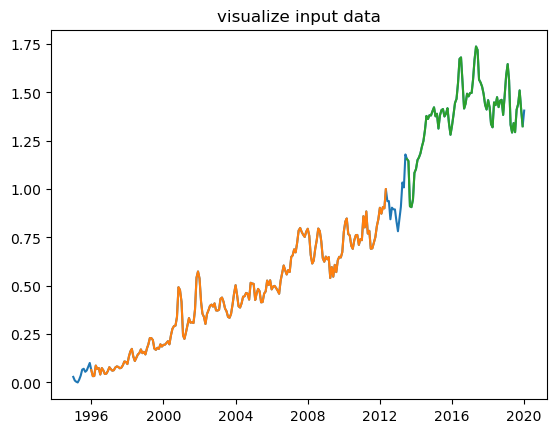

In [9]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [10]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


2023-05-09 15:08:27.661227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
7/7 [==============================] - 3s 106ms/step - loss: 0.2011 - mean_absolute_error: 0.3786 - val_loss: 0.6924 - val_mean_absolute_error: 0.8224
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0358 - mean_absolute_error: 0.1448 - val_loss: 0.0311 - val_mean_absolute_error: 0.1492
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0175 - mean_absolute_error: 0.1194 - val_loss: 0.0120 - val_mean_absolute_error: 0.0863
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0126 - mean_absolute_error: 0.0977 - val_loss: 0.0679 - val_mean_absolute_error: 0.2379
Epoch 5/50
7/7 [==============================] - 0s 48ms/step - loss: 0.0081 - mean_absolute_error: 0.0720 - val_loss: 0.0972 - val_mean_absolute_error: 0.2929
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0078 - mean_absolute_error: 0.0689 - val_loss: 0.0535 - val_mean_absolute_error: 0.2060
Epoch 7/50
7/7 [=================

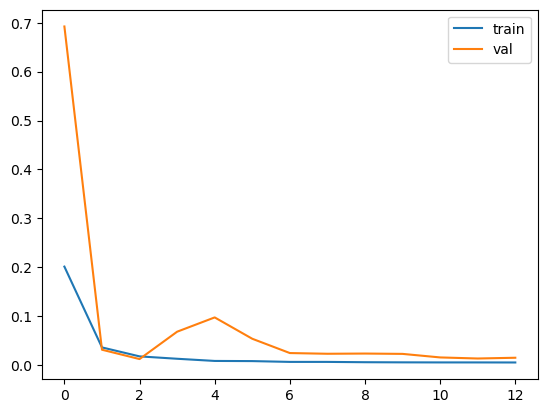

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [12]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 4ms/step


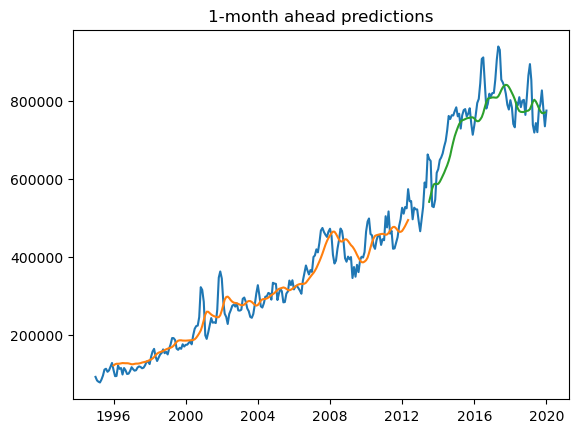

In [13]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


In [14]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
# y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
# y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [15]:
y_1mo_train_rescaled.shape

(197, 1)

In [16]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled,
                           y_1mo_train_rescaled))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled,
                           y_1mo_test_rescaled))))

# print('Train 12mo RMSE: {}'.format(
#     np.sqrt(
#         mean_squared_error(pred_12mo_train_rescaled[:, 0],
#                            y_12mo_train_rescaled[:, 0]))))
# print('Test 12mo RMSE: {}'.format(
#     np.sqrt(
#         mean_squared_error(pred_12mo_test_rescaled[:, 0],
#                            y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 34780.64355505956
Test 1mo RMSE: 60145.996594021235


### multiple features

#### data

In [17]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [18]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


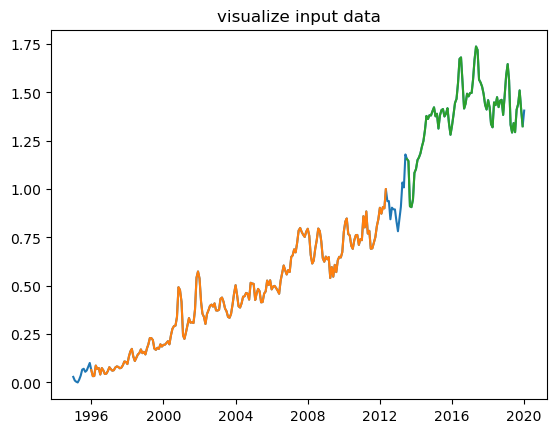

In [19]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [20]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 2s 82ms/step - loss: 0.1229 - mean_absolute_error: 0.2724 - val_loss: 0.5570 - val_mean_absolute_error: 0.6107
Epoch 2/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0383 - mean_absolute_error: 0.1470 - val_loss: 0.5686 - val_mean_absolute_error: 0.5682
Epoch 3/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0286 - mean_absolute_error: 0.1149 - val_loss: 0.4560 - val_mean_absolute_error: 0.5106
Epoch 4/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0241 - mean_absolute_error: 0.1037 - val_loss: 0.3025 - val_mean_absolute_error: 0.4353
Epoch 5/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0220 - mean_absolute_error: 0.1007 - val_loss: 0.3717 - val_mean_absolute_error: 0.4688
Epoch 6/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0201 - mean_absolute_error: 0.0914 - val_loss: 0.3874 - val_mean_absolute_error: 0.4880
Epoch 7/100
7/7 [===========

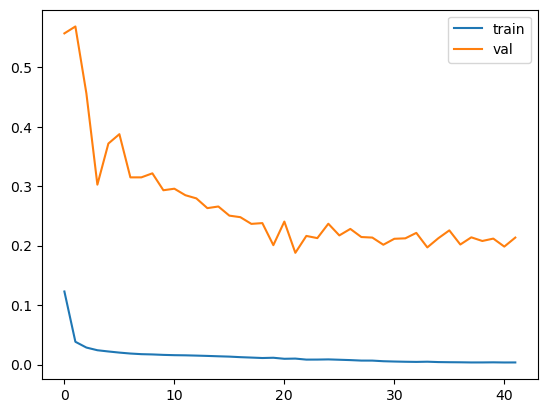

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [22]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 7ms/step


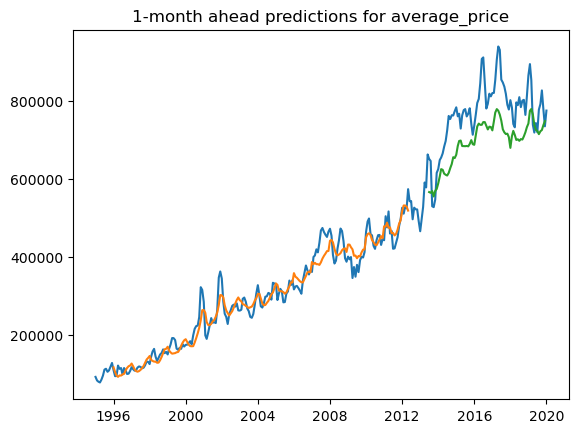

In [23]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


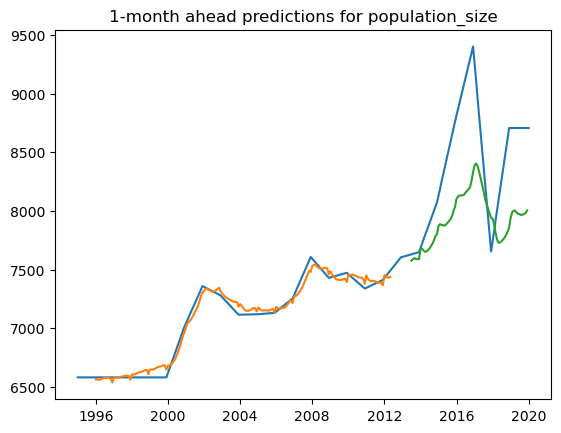

In [24]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [25]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
# y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
# y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [26]:
y_1mo_train_rescaled.shape

(197, 8)

In [27]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

# print('Train 12mo RMSE: {}'.format(
#     np.sqrt(
#         mean_squared_error(pred_12mo_train_rescaled[:, 0],
#                            y_12mo_train_rescaled[:, 0]))))
# print('Test 12mo RMSE: {}'.format(
#     np.sqrt(
#         mean_squared_error(pred_12mo_test_rescaled[:, 0],
#                            y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 26399.942868921225
Test 1mo RMSE: 88328.28391817707


### predict diff

#### data

In [28]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [29]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


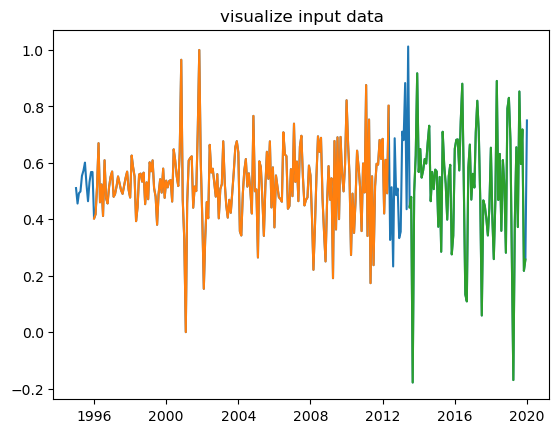

In [30]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [31]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 2s 100ms/step - loss: 0.1609 - mean_absolute_error: 0.3743 - val_loss: 0.0651 - val_mean_absolute_error: 0.2083
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0280 - mean_absolute_error: 0.1296 - val_loss: 0.0787 - val_mean_absolute_error: 0.2120
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0335 - mean_absolute_error: 0.1419 - val_loss: 0.0508 - val_mean_absolute_error: 0.1652
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0192 - mean_absolute_error: 0.1020 - val_loss: 0.0516 - val_mean_absolute_error: 0.1734
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0224 - mean_absolute_error: 0.1145 - val_loss: 0.0507 - val_mean_absolute_error: 0.1707
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0191 - mean_absolute_error: 0.1032 - val_loss: 0.0509 - val_mean_absolute_error: 0.1652
Epoch 7/50
7/7 [=================

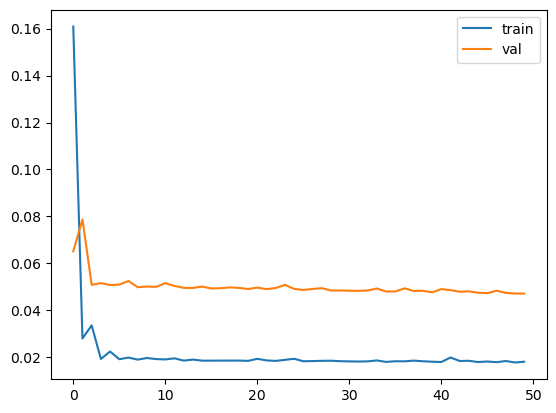

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [33]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 5ms/step


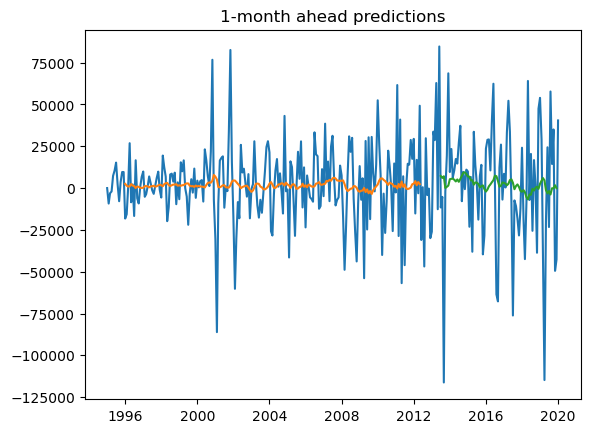

In [34]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

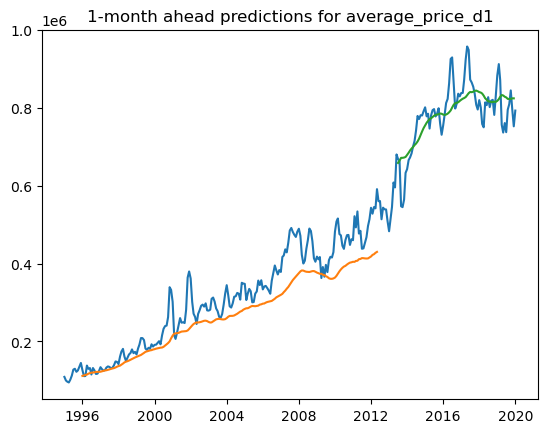

In [35]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [36]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [37]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


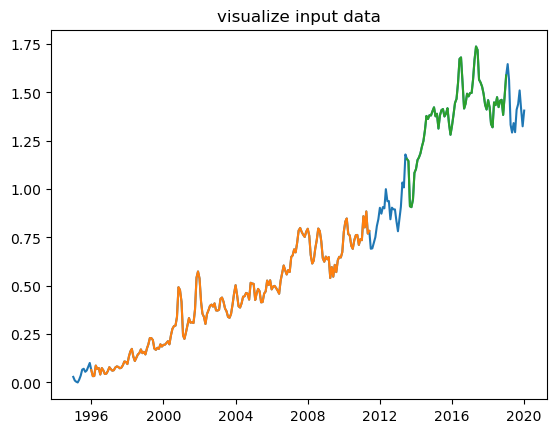

In [38]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [39]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 5s 139ms/step - loss: 0.1962 - mean_absolute_error: 0.3853 - val_loss: 1.0938 - val_mean_absolute_error: 1.0370
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0599 - mean_absolute_error: 0.1920 - val_loss: 0.0542 - val_mean_absolute_error: 0.1981
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0292 - mean_absolute_error: 0.1459 - val_loss: 0.0711 - val_mean_absolute_error: 0.2400
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0127 - mean_absolute_error: 0.0915 - val_loss: 0.2804 - val_mean_absolute_error: 0.5161
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0181 - mean_absolute_error: 0.1054 - val_loss: 0.1992 - val_mean_absolute_error: 0.4315
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0114 - mean_absolute_error: 0.0879 - val_loss: 0.0631 - val_mean_absolute_error: 0.2252
Epoch 7/50
6/6 [=================

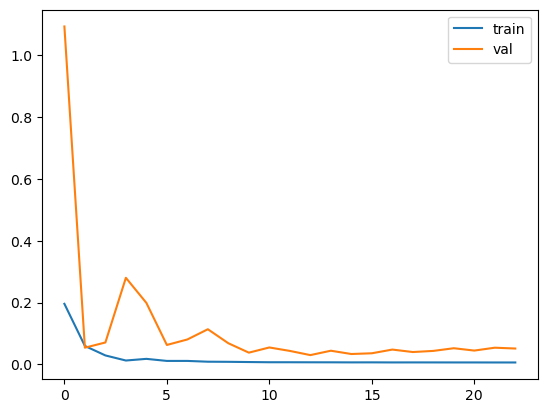

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [41]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 5ms/step


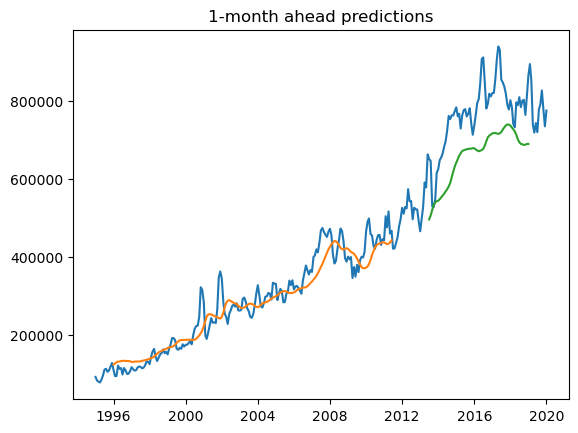

In [42]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

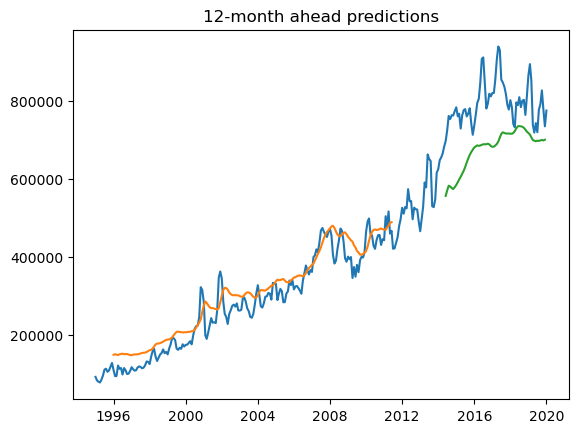

In [43]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


In [44]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [45]:
y_1mo_train_rescaled.shape

(186, 1)

In [46]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled,
                           y_1mo_train_rescaled))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled,
                           y_1mo_test_rescaled))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled,
                           y_12mo_train_rescaled))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled,
                           y_12mo_test_rescaled))))


Train 1mo RMSE: 38063.456207552656
Test 1mo RMSE: 120447.91743089851
Train 12mo RMSE: 43283.00103735824
Test 12mo RMSE: 130537.57876258226


### multiple features

#### data setup

In [47]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [48]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


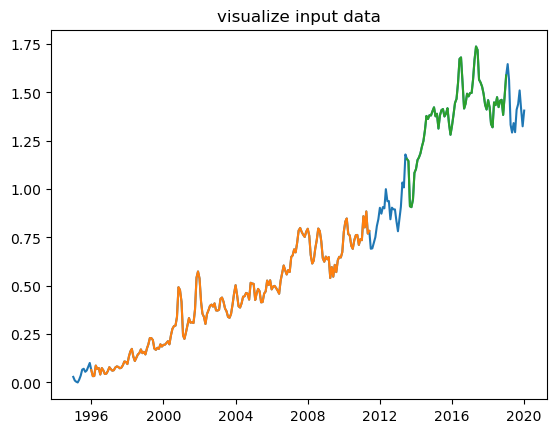

In [49]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [50]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 4s 160ms/step - loss: 0.1370 - mean_absolute_error: 0.2919 - val_loss: 0.7075 - val_mean_absolute_error: 0.6406
Epoch 2/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0513 - mean_absolute_error: 0.1730 - val_loss: 0.8233 - val_mean_absolute_error: 0.6529
Epoch 3/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0330 - mean_absolute_error: 0.1412 - val_loss: 0.7477 - val_mean_absolute_error: 0.6027
Epoch 4/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0275 - mean_absolute_error: 0.1201 - val_loss: 0.6663 - val_mean_absolute_error: 0.5932
Epoch 5/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0247 - mean_absolute_error: 0.1129 - val_loss: 0.6623 - val_mean_absolute_error: 0.5808
Epoch 6/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0222 - mean_absolute_error: 0.0987 - val_loss: 0.6510 - val_mean_absolute_error: 0.5751
Epoch 7/100
6/6 [==========

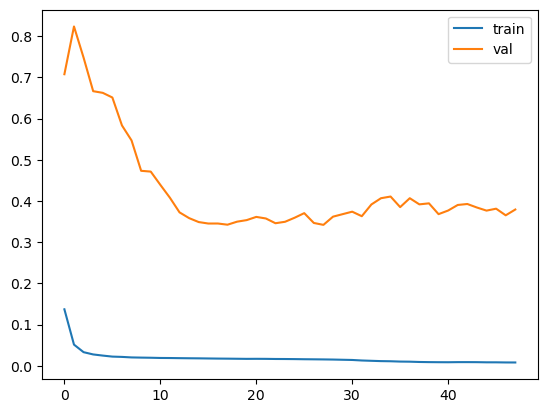

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [52]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 8ms/step


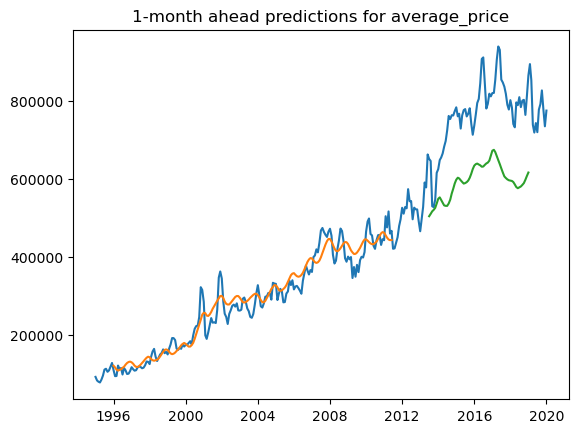

In [53]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


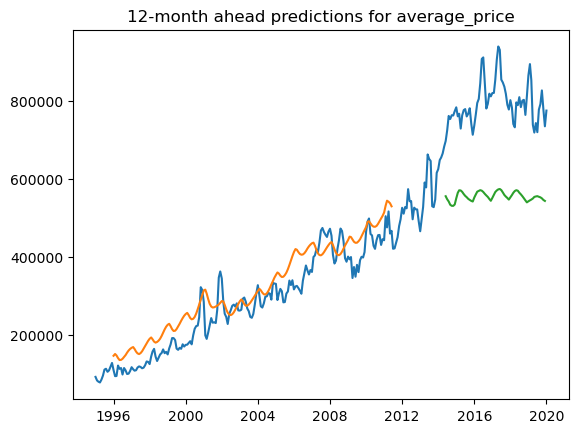

In [54]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


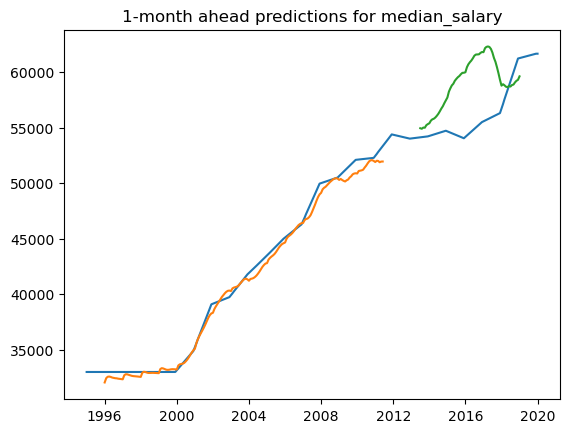

In [55]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [56]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [57]:
y_1mo_train_rescaled.shape

(186, 8)

In [58]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 29282.135925486866
Test 1mo RMSE: 182860.2007001092
Train 12mo RMSE: 31168.316440146533
Test 12mo RMSE: 244723.78231856722


### predict diff

#### data

In [59]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [60]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


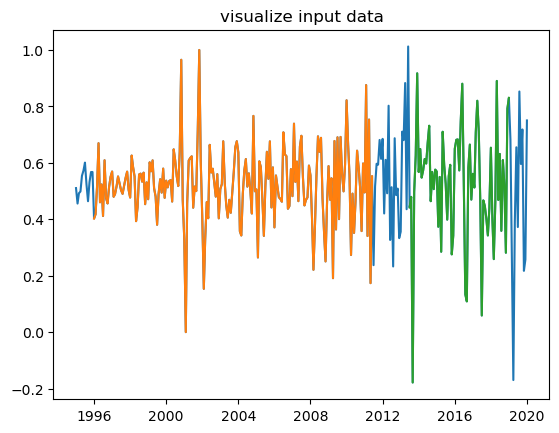

In [61]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [62]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 4s 125ms/step - loss: 0.2013 - mean_absolute_error: 0.4249 - val_loss: 0.1047 - val_mean_absolute_error: 0.2836
Epoch 2/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0435 - mean_absolute_error: 0.1688 - val_loss: 0.0812 - val_mean_absolute_error: 0.2243
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0333 - mean_absolute_error: 0.1404 - val_loss: 0.0423 - val_mean_absolute_error: 0.1595
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0242 - mean_absolute_error: 0.1224 - val_loss: 0.0490 - val_mean_absolute_error: 0.1780
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0227 - mean_absolute_error: 0.1162 - val_loss: 0.0410 - val_mean_absolute_error: 0.1542
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0187 - mean_absolute_error: 0.0994 - val_loss: 0.0438 - val_mean_absolute_error: 0.1564
Epoch 7/50
6/6 [=================

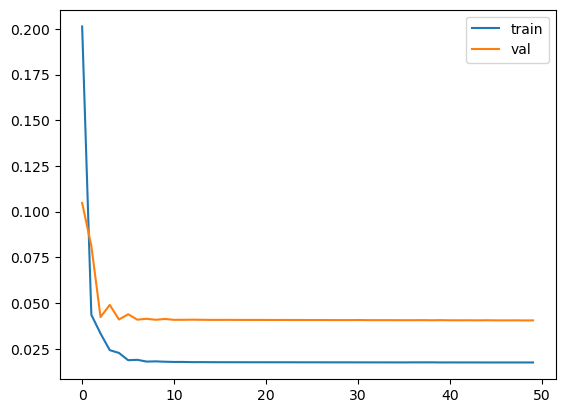

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [64]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 5ms/step


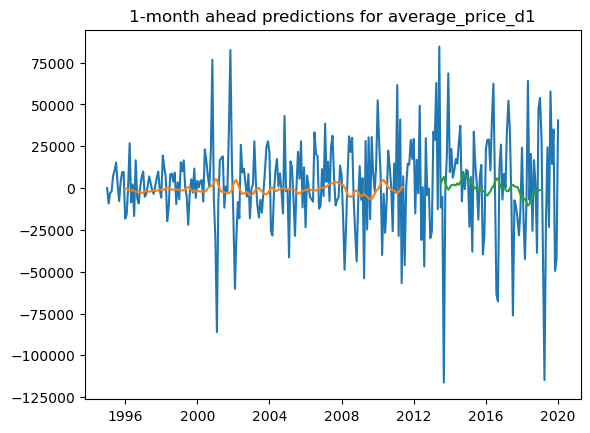

In [65]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


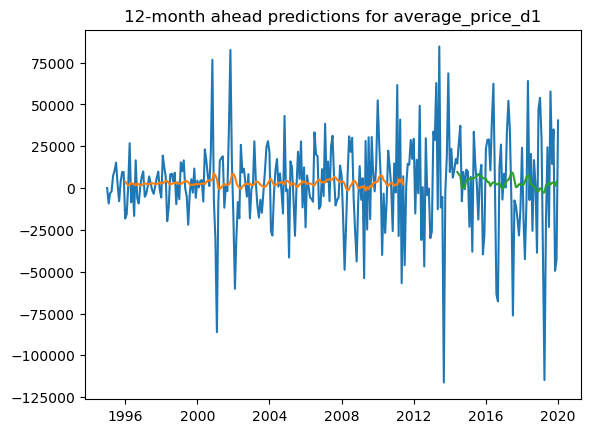

In [66]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


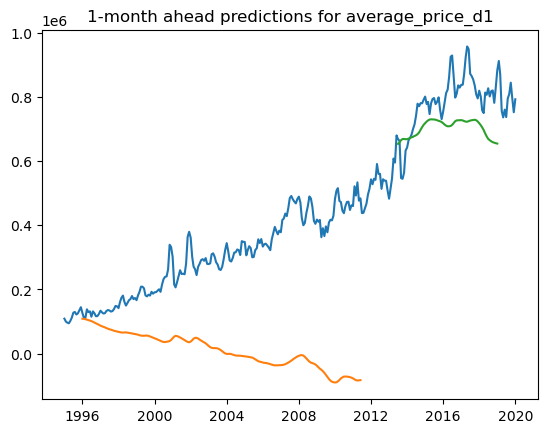

In [67]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


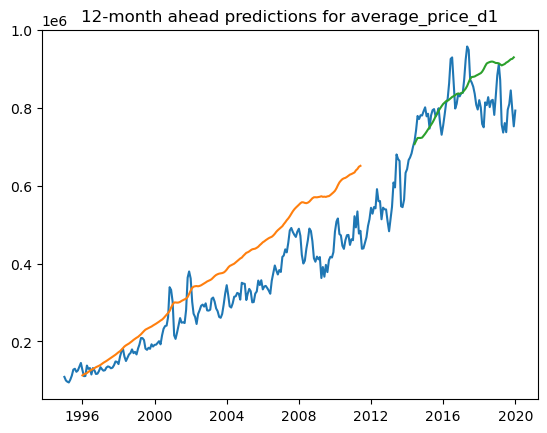

In [68]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
